### Import lib

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import pickle

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from pandarallel import pandarallel

# Initialization
pandarallel.initialize(progress_bar=True)

import warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Import phishing_site_urls dataset

In [4]:
# Read the urls database
urls_df = pd.read_csv(r'phishing_site_urls.csv')

# Rename the column
urls_df.rename(columns = {'URL':'Content'}, inplace = True)
urls_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  549346 non-null  object
 1   Label    549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [5]:
urls_df.sample(10)

,Content,Label
153373,brp-architects.blogspot.com/,good
431724,skillwho.com/lists/H/H0/157702/,good
21456,estudiog.com.ar/,bad
339177,flickr.com/photos/haglundc/3946685535/,good
52564,www.quicken.com/banking_and_credit/billpay/,good
326594,facebook.com/bernard.bujold,good
491024,helpus.su/extralog/admin.php,bad
462353,webdirectorygo.com/architecture/chapel/calvary...,good
159323,club.whitecapsfc.com/women/schedule/,good
354100,hoovers.com/company/Molson_Coors_Brewing_Compa...,good


In [6]:
urls_df.isnull().sum()

Content    0
Label      0
dtype: int64

In [7]:
label_counter = pd.DataFrame(urls_df.Label.value_counts())

In [8]:
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.show()

good    392924
bad     156422
Name: Label, dtype: int64


,Content,Label
0,"Subject: re : amitava ' s visit\n bryan ,\n i ...",good
1,"Subject: happy thanksgiving !\n hello , vince ...",good
2,Subject: beaver creek biking\n per our convers...,good
3,Subject: western issues 7 / 23 / 01\n below is...,good
4,"Subject: deals entered 3 / 01\n julie ,\n i ha...",good
5,Subject: el paso order on complaint\n attached...,good
6,"Subject: louise , although i am very much a su...",good
7,"Subject: caithness big sandy , llc . project\n...",good
8,Subject: status of hpl transfers to aep\n sall...,good
9,Subject: fw : tw flow direction\n kim and lind...,good


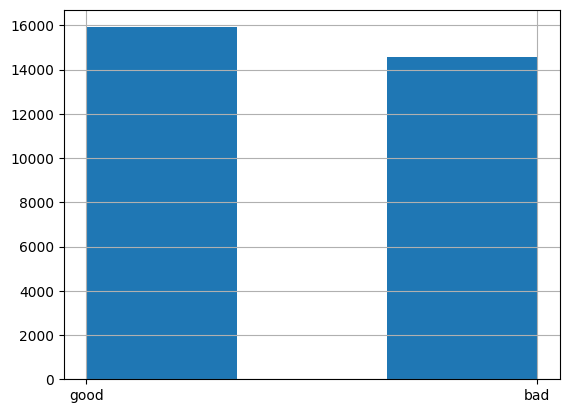

In [9]:
from os import walk
# Read the emails database
pathwalk = walk(r"enron-spam/")

allHamData, allSpamData = [], []
for root, dr, file in pathwalk:
    if 'ham' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allHamData.append(" ".join(ip.readlines()))

    elif 'spam' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allSpamData.append(" ".join(ip.readlines()))
                # remove all redundant data

allHamData = list(set(allHamData))
allSpamData = list(set(allSpamData))
# storing it in a dataframe

hamPlusSpamData = allHamData + allSpamData
labels = ["good"]*len(allHamData) + ["bad"]*len(allSpamData)

emails_df = pd.DataFrame({"Content": hamPlusSpamData,
                       "Label": labels})

# get an overview of the data

emails_df.Label.hist(bins=3)
emails_df.head(10)

In [10]:
# merge database
all_df = pd.concat([urls_df, emails_df], axis=0)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579840 entries, 0 to 30493
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  579840 non-null  object
 1   Label    579840 non-null  object
dtypes: object(2)
memory usage: 13.3+ MB


### Preprocessing

In [11]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
all_df.Content[0]

0    nobell.it/70ffb52d079109dca5664cce6f317373782/...
0    Subject: re : amitava ' s visit\n bryan ,\n i ...
Name: Content, dtype: object

In [12]:
tokenizer.tokenize(urls_df.Content[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [13]:
all_df['text_tokenized'] = all_df.Content.parallel_map(lambda t: tokenizer.tokenize(t))

/home/alex/.local/lib/python3.10/site-packages/pandarallel/data_types/series.py:42: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [14]:
all_df.sample(5)

,Content,Label,text_tokenized
18480,www.118bm.com/images/?us.battle.net/login/en/?...,bad,"[www, bm, com, images, us, battle, net, login,..."
366251,jonathanformayor.com/,good,"[jonathanformayor, com]"
36017,steamboom.gegahost.net/,bad,"[steamboom, gegahost, net]"
424121,rockdiscography.com/quebec/bandaltqc.html,good,"[rockdiscography, com, quebec, bandaltqc, html]"
506851,bocris.ro/d22eop2,bad,"[bocris, ro, d, eop]"


In [15]:
stemmer = SnowballStemmer("english")
all_df['text_stemmed'] = all_df['text_tokenized'].parallel_map(lambda l: [stemmer.stem(word) for word in l])


/home/alex/.local/lib/python3.10/site-packages/pandarallel/data_types/series.py:42: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [16]:
all_df.sample(5)

,Content,Label,text_tokenized,text_stemmed
16465,www.clement.com.ar/inproldet.html,bad,"[www, clement, com, ar, inproldet, html]","[www, clement, com, ar, inproldet, html]"
191719,gallery.bustalk.info/index.php?cat=5,good,"[gallery, bustalk, info, index, php, cat]","[galleri, bustalk, info, index, php, cat]"
523724,wienu.com/owe/admin.php,bad,"[wienu, com, owe, admin, php]","[wienu, com, owe, admin, php]"
75527,www.e-t.com/jshrink.html,good,"[www, e, t, com, jshrink, html]","[www, e, t, com, jshrink, html]"
527326,cognimuse.cs.ntua.gr/search.php,bad,"[cognimuse, cs, ntua, gr, search, php]","[cognimus, cs, ntua, gr, search, php]"


In [17]:
all_df['text_sent'] = all_df['text_stemmed'].parallel_map(lambda l: ' '.join(l))

/home/alex/.local/lib/python3.10/site-packages/pandarallel/data_types/series.py:42: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [18]:
all_df.sample(5)

,Content,Label,text_tokenized,text_stemmed,text_sent
503089,izmirisgb.com/dknjf,bad,"[izmirisgb, com, dknjf]","[izmirisgb, com, dknjf]",izmirisgb com dknjf
103921,ofenbinder.com/media/mambots/search/ceo/Arch/A...,bad,"[ofenbinder, com, media, mambots, search, ceo,...","[ofenbind, com, media, mambot, search, ceo, ar...",ofenbind com media mambot search ceo arch archiv
350785,helioselectric.com/sales/index.php?main_page=p...,good,"[helioselectric, com, sales, index, php, main,...","[helioselectr, com, sale, index, php, main, pa...",helioselectr com sale index php main page prod...
60550,www.equisys.com/products/zetafax,good,"[www, equisys, com, products, zetafax]","[www, equisi, com, product, zetafax]",www equisi com product zetafax
3578,'www.cielofidelidade.com.br/Login.aspx?ReturnU...,bad,"[www, cielofidelidade, com, br, Login, aspx, R...","[www, cielofidelidad, com, br, login, aspx, re...",www cielofidelidad com br login aspx returnurl f


### Visualization

In [19]:
bad_sites = all_df[all_df.Label == 'bad']
good_sites = all_df[all_df.Label == 'good']

In [20]:
bad_sites.head()

,Content,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [21]:
good_sites.head()

,Content,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


### Creating Model

In [22]:
cv = CountVectorizer()
feature = cv.fit_transform(all_df.text_sent)

In [23]:
feature[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
trainX, testX, trainY, testY = train_test_split(feature, all_df.Label)

In [25]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from numpy import argmax

def build_and_test(X_tr, X_te, y_tr, y_te, class_weight=None, threshold=False):
    # Build and Plot PCA
    pca = PCA(n_components=2)
    pca.fit(X_tr.toarray())
    X_pca = pca.transform(X_tr.toarray())



In [26]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# Make undersampling to decreases the number of samples of the 
# biggest class down to the size of the smallest class

under_sampler = RandomUnderSampler(random_state=0)
trainX, trainY = under_sampler.fit_resample(trainX, trainY)
print(f"Training target statistics: {Counter(trainY)}")
print(f"Testing target statistics: {Counter(testY)}")

Training target statistics: Counter({'bad': 128134, 'good': 128134})
Testing target statistics: Counter({'good': 102088, 'bad': 42872})


In [27]:
#roc_auc_rus,fpr_rus,tpr_rus , _ = build_and_test(X_under, testX, y_under, testY)

### Logistic Regression

In [28]:
lr = LogisticRegression()
lr.fit(trainX,trainY)
lr.score(testX,testY)

/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9577745584988963

In [29]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9774415845911312
Testing Accuracy : 0.9577745584988963

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.94      0.92      0.93     44277
        Good       0.96      0.98      0.97    100683

    accuracy                           0.96    144960
   macro avg       0.95      0.95      0.95    144960
weighted avg       0.96      0.96      0.96    144960


CONFUSION MATRIX


<AxesSubplot: >

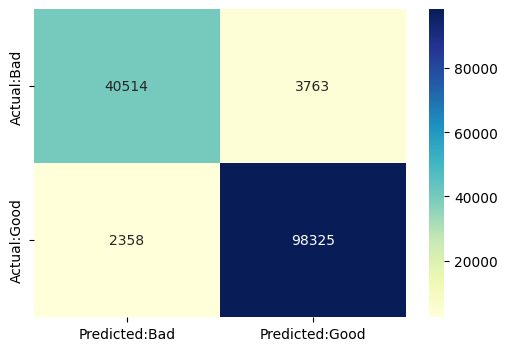

In [30]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### Cross Validation

In [39]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold_validation=KFold(10)

# apply cross validation to Logistic Regeression model
results=cross_val_score(lr,testX,testY,cv=kfold_validation)
print(results)
print(np.mean(results))

[0.95219371 0.9477787  0.94888245 0.9481926  0.95074503 0.94950331
 0.9477787  0.94750276 0.95115894 0.94881347]
0.9492549668874173


### Multinomial Naive Bayes

In [48]:
mnb = MultinomialNB()
mnb.fit(trainX,trainY)
mnb.score(testX,testY)

0.9473371964679912

In [49]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.9693596788651155
Testing Accuracy : 0.9473371964679912

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.94      0.89      0.91     45399
        Good       0.95      0.98      0.96     99561

    accuracy                           0.95    144960
   macro avg       0.95      0.93      0.94    144960
weighted avg       0.95      0.95      0.95    144960


CONFUSION MATRIX


<AxesSubplot: >

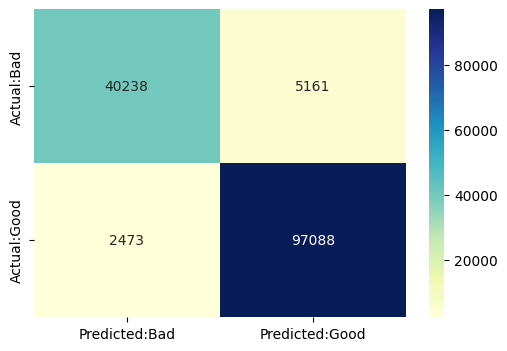

In [50]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### Support Vector Machine

In [52]:
X_train, X_test, y_train, y_test = train_test_split(feature, all_df.Label, test_size=0.25, random_state=27)
under_sampler = RandomUnderSampler(random_state=27)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(testY)}")


Training target statistics: Counter({'bad': 128247, 'good': 128247})
Testing target statistics: Counter({'good': 102249, 'bad': 42711})


In [53]:
SVC_model = svm.SVC(kernel='linear')

In [54]:
SVC_model.fit(X_train, y_train)

In [ ]:
SVC_prediction = SVC_model.predict(X_test)

In [ ]:
print(confusion_matrix(SVC_prediction, y_test))

### KNN_model

In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=3)

KNN_model.fit(X_train, y_train)

KNN_prediction = KNN_model.predict(X_test)
print(classification_report(KNN_prediction, y_test))

In [ ]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(x=acc.index,y=acc.Accuracy)
print(acc.Accuracy)

### sklearn pipeline with Logistic Regression

In [ ]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())

In [ ]:
trainX, testX, trainY, testY = train_test_split(all_df.Content, all_df.Label)
under_sampler = RandomUnderSampler(random_state=0)
trainX, trainY = under_sampler.fit_resample(trainX, trainY)
print(f"Training target statistics: {Counter(trainY)}")
print(f"Testing target statistics: {Counter(testY)}")

In [ ]:
pipeline_ls.fit(trainX,trainY)

In [ ]:
pipeline_ls.score(testX,testY) 

In [ ]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
pickle.dump(pipeline_ls,open('phishing_LR.pkl','wb'))
loaded_model = pickle.load(open('phishing_LR.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

In [ ]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['whitehouse.gov/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing_LR.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

# Test SVC model

In [ ]:
# Support Vector Machine
from sklearn import svm
SVC_model = svm.SVC(kernel='linear')
SVC_model.fit(X_train, y_train)
SVC_prediction = SVC_model.predict(X_test)
# But Confusion Matrix and Classification Report give more details about performance
print(confusion_matrix(SVC_prediction, y_test))
# Accuracy score is the simplest way to evaluate
print(accuracy_score(SVC_prediction, y_test))

# sklearn pipeline using SVC
from sklearn.pipeline import make_pipeline
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), svm.SVC(kernel='linear'))
X_train, X_test, y_train, y_test = train_test_split(all_df.Content, all_df.Label)
under_sampler = RandomUnderSampler(random_state=0)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)
pipeline_ls.fit(X_train,y_train)
pipeline_ls.score(X_test, y_test)

print('Training Accuracy :',pipeline_ls.score(X_train,y_train))
print('Testing Accuracy :',pipeline_ls.score(X_test,y_test))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(X_test), y_test),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(X_test), y_test,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

import pickle
pickle.dump(pipeline_ls,open('phishing_SVC.pkl','wb'))
loaded_model = pickle.load(open('phishing_SVC.pkl', 'rb'))
result = loaded_model.score(X_test,y_test)
print(result)

In [ ]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['whitehouse.gov','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing_SVC.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)